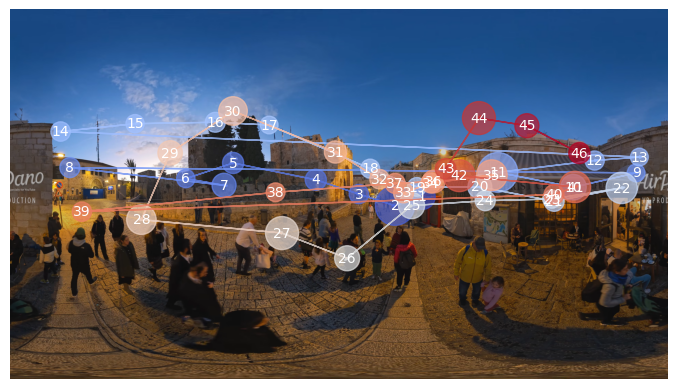

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from PIL import Image

def visualize_fixation(scan_path_csv, scene_image_path):
    # Check if the fixation CSV file exists
    if not os.path.exists(scan_path_csv):
        print(f"Error: Fixation CSV file not found at {scan_path_csv}")
        return

    # Check if the scene image exists
    if not os.path.exists(scene_image_path):
        print(f"Error: Scene image not found at {scene_image_path}")
        return

    # Load fixation data
    df = pd.read_csv(scan_path_csv)

    # Extract fixation points and durations
    fixation_points = []
    durations = []
    timestamps = []

    current_fixation = []
    current_start_time = None

    for i, row in df.iterrows():
        if row['is_fixation'] == 1:
            current_fixation.append((row['lon'], row['lat'], row['timestamp']))
            if current_start_time is None:
                current_start_time = row['timestamp']
        else:
            if current_fixation:
                # Compute average point and duration
                avg_lon = np.mean([p[0] for p in current_fixation])
                avg_lat = np.mean([p[1] for p in current_fixation])
                avg_time = np.mean([p[2] for p in current_fixation])
                duration = current_fixation[-1][2] - current_start_time

                fixation_points.append((avg_lon, avg_lat))
                durations.append(duration)
                timestamps.append(avg_time)

                current_fixation = []
                current_start_time = None

    # Normalize timestamps for color mapping
    norm = mcolors.Normalize(vmin=min(timestamps), vmax=max(timestamps))
    cmap = plt.get_cmap('coolwarm')  # Red to blue transition

    # Load scene image
    scene_image = Image.open(scene_image_path)

    # Plot the 360 scene image
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(scene_image)

    # Plot fixation points and arrows
    prev_x, prev_y = None, None
    for idx, ((lon, lat), duration, timestamp) in enumerate(zip(fixation_points, durations, timestamps)):
        # Map longitude and latitude to image pixels
        x = (lon + 180) / 360 * scene_image.size[0]
        y = (90 - lat) / 180 * scene_image.size[1]

        # Scale radius by duration (5 times larger)
        radius = (10 + duration * 10) * 5
        color = cmap(norm(timestamp))

        circle = plt.Circle((x, y), radius, color=color, alpha=0.7)
        ax.add_artist(circle)

        # Add index to the circle
        ax.text(x, y, str(idx + 1), color="white", fontsize=10, ha='center', va='center')

        # Draw arrow from previous fixation point to current one
        if prev_x is not None and prev_y is not None:
            ax.arrow(prev_x, prev_y, x - prev_x, y - prev_y,
                     head_width=15, head_length=20, fc=color, ec=color, alpha=0.8)

        prev_x, prev_y = x, y

    # Add colorbar for time visualization without label
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05)
    cbar.ax.set_xticklabels([])  # Remove labels

    # Remove title, labels, and frame
    ax.set_title("")
    ax.axis("off")
    cbar.remove()

    plt.show()

# Example input paths
scan_path_csv = Path("data/raw_gaze/jaffa_gate/fixation_data/20241202_121327_fixation.csv")
scene_image_path = Path("data/stimuli/jaffa_gate.png")

# Visualize fixation scan path
visualize_fixation(scan_path_csv, scene_image_path)
